In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import pandas as pd
import flexiznam as flz
from skimage.measure import EllipseModel
import matplotlib.pyplot as plt
import numpy as np
import cv2
from cottage_analysis.utilities.plot_utils import get_img_from_fig, write_fig_to_video
from cottage_analysis.eye_tracking import eye_model_fitting


# Load DLC results

In [3]:
raw = Path(flz.PARAMETERS["data_root"]["raw"])
processed = Path(flz.PARAMETERS["data_root"]["processed"])
project = "blota_onix_pilote"
mouse = "BRAC6692.4a"
session = "S20221216"
recording = "Arena_dark_floor"
camera = "eye_camera"


data_path = processed / project / mouse / session / recording / camera
dlc_path = data_path / "dlc_output"
dlc_results = dict()
for fname in dlc_path.glob("*.h5"):
    dlc_results[fname.name] = pd.read_hdf(fname)
for k, v in dlc_results.items():
    print("Read %s with %s entries" % (k, len(v)))

fname = [fname for fname in dlc_results if "filtered" not in fname]
print("Found %d recordings" % len(fname))




Read eye_camera_2022-11-25T15_49_23_croppedDLC_resnet50_eye_trackingDec1shuffle1_1030000_filtered.h5 with 19070 entries
Read eye_camera_2022-12-16T11_26_01_croppedDLC_resnet50_eye_trackingDec1shuffle1_1030000_filtered.h5 with 27354 entries
Read eye_camera_2022-12-16T11_26_01_croppedDLC_resnet50_eye_trackingDec1shuffle1_1030000.h5 with 27354 entries
Read eye_camera_2022-11-25T15_49_23_croppedDLC_resnet50_eye_trackingDec1shuffle1_1030000.h5 with 19070 entries
Found 2 recordings


# Chose which to analyse

In [4]:
# model = "eye_camera_2022-11-25T15_49_23_croppedDLC_resnet50_eye_trackingDec1shuffle1_1030000.h5"


# Fit ellipses

In [5]:
REDO = False
all_fits = dict()
for model in dlc_results:
    print('Doing %s' % model)
    target = dlc_path / "ellipse_fit" / "{0}_fit.h5".format(model.replace(".h5", ""))
    target.parent.mkdir(exist_ok=True)
    
    if target.exists() and not REDO:
        ellipse_fits = pd.read_csv(target)
        print("Fit loaded")
    else:
        ellipse_fits = eye_model_fitting.fit_ellipses(dlc_results[model])
        ellipse_fits.to_csv(target, index=False)
        print("Fit created and saved")
    all_fits[model] = ellipse_fits


Doing eye_camera_2022-11-25T15_49_23_croppedDLC_resnet50_eye_trackingDec1shuffle1_1030000_filtered.h5
Fit created and saved
Doing eye_camera_2022-12-16T11_26_01_croppedDLC_resnet50_eye_trackingDec1shuffle1_1030000_filtered.h5
Fit created and saved
Doing eye_camera_2022-12-16T11_26_01_croppedDLC_resnet50_eye_trackingDec1shuffle1_1030000.h5
Fit created and saved
Doing eye_camera_2022-11-25T15_49_23_croppedDLC_resnet50_eye_trackingDec1shuffle1_1030000.h5
Fit created and saved


# Find moment where the mouse looks back

These were badly fitted, try to get that better.

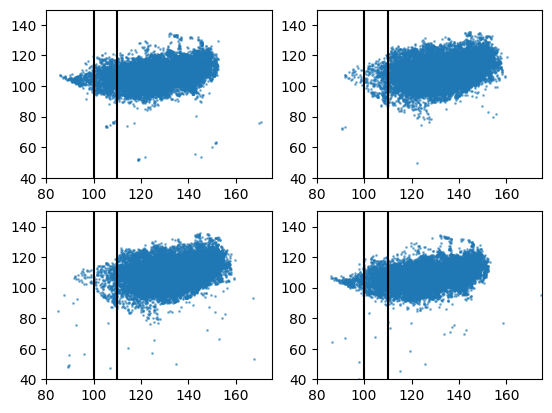

In [6]:
fig = plt.figure()
xlim = [100, 110]
for imodel, model in enumerate(dlc_results):
    fits = all_fits[model]

    ax = fig.add_subplot(2, 2, imodel + 1)
    ax.scatter(fits.centre_x.values, fits.centre_y.values, s=1, alpha=0.5)
    ax.set_xlim(80, 175)
    ax.set_ylim(40, 150)
    for l in xlim:
        ax.axvline(l, color='k')


In [12]:
model

'eye_camera_2022-11-25T15_49_23_croppedDLC_resnet50_eye_trackingDec1shuffle1_1030000.h5'

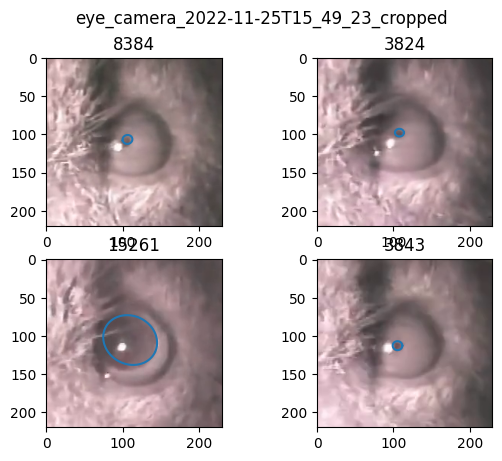

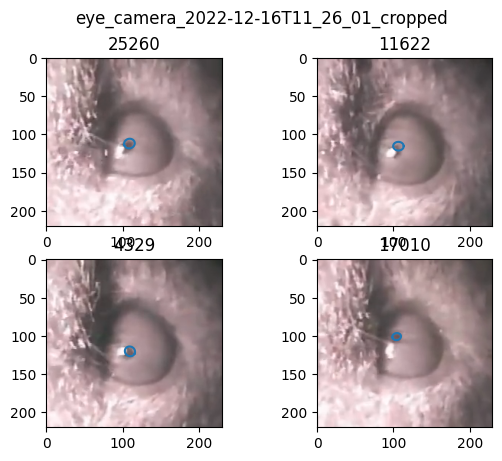

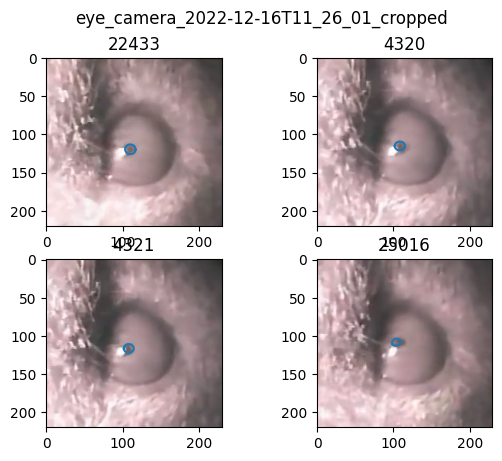

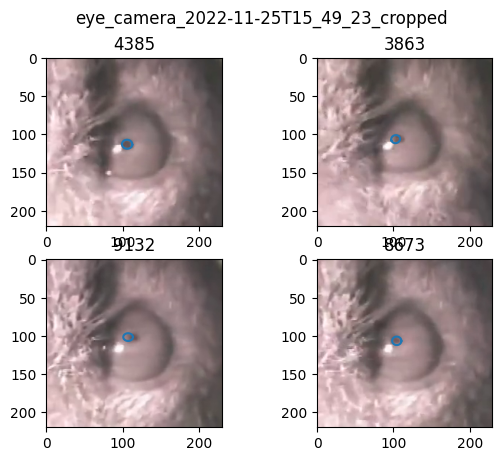

In [14]:
from numpy.random import default_rng

rng = default_rng(seed=756)
ellipse = EllipseModel()
base_dir = processed/ project / mouse / session / 'example_frames'
base_dir.mkdir(exist_ok=True)
for imodel, model in enumerate(dlc_results):
    target_dir = base_dir / f"{model[:model.find('DLC')]}"
    target_dir.mkdir(exist_ok=True)
    video_file = data_path / "{0}.mp4".format(model[: model.find("DLC")])
    fits = all_fits[model]
    ok, = np.where((fits.centre_x.values < xlim[1]) & (fits.centre_x.values > xlim[0]))
    # take 4 random frames
    frame_id = ok[rng.integers(0, len(ok)-1, 4)]
    cam_data = cv2.VideoCapture(str(video_file))
    fig = plt.figure()
    fig.suptitle(model[:model.find('DLC')])
    for iframe, fid in enumerate(frame_id):
        ax = fig.add_subplot(2, 2, iframe+1)
        cam_data.set(cv2.CAP_PROP_POS_FRAMES, fid-1)
        ret, frame = cam_data.read()
        ax.imshow(frame)
        ax.set_title(fid)
        fit = fits.iloc[fid]
        ellipse.params = [fit[w] for w in 
            ("centre_x", "centre_y", "major_radius", "minor_radius", "angle")]
        circ_coord = ellipse.predict_xy(np.arange(0, 2 * np.pi, 0.1))
        ax.plot(circ_coord[:, 0], circ_coord[:, 1])
        cv2.imwrite(str(target_dir / f"img{fid:05d}.png"), frame)
    cam_data.release()





In [34]:
frame = 283

fig = plt.figure()
for i in range(3):
    ax = fig.add_subplot(1,2,1 + i)

3.0050177737353287

## Plot a movie with ellipse fits

In [5]:
target_file = dlc_path / "eye_tracking_ellipse_not_filtered.mp4"
video_file = data_path / "{0}.mp4".format(model[: model.find("DLC")])

assert target_file.parent.is_dir()
REDO = False
if not target_file.exists() or REDO:
    ellipse = EllipseModel()

    dlc_res = dlc_results[model]
    ellipse_fits = []

    fig = plt.figure()
    fig.set_size_inches((9, 3))

    img = get_img_from_fig(fig)
    cam_data = cv2.VideoCapture(str(video_file))
    fps = cam_data.get(cv2.CAP_PROP_FPS)
    fcc = int(cam_data.get(cv2.CAP_PROP_FOURCC))
    fcc = (
        chr(fcc & 0xFF)
        + chr((fcc >> 8) & 0xFF)
        + chr((fcc >> 16) & 0xFF)
        + chr((fcc >> 24) & 0xFF)
    )

    output = cv2.VideoWriter(
        str(target_file),
        cv2.VideoWriter_fourcc(*fcc),
        fps / 4,
        (img.shape[1], img.shape[0]),
    )

    for frame_id, track in dlc_res.iterrows():
        # plot
        fig.clear()
        ax_img = fig.add_subplot(1, 3, 1)
        ax_track = fig.add_subplot(1, 3, 2)
        ax_fit = fig.add_subplot(1, 3, 3)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)

        ret, frame = cam_data.read()

        for ax in [ax_img, ax_fit, ax_track]:
            ax.imshow(frame)
            ax.set_yticks([])
            ax.set_xticks([])

        ax_track.scatter(xdata, ydata, s=likelihood * 10)
        circ_coord = ellipse.predict_xy(np.arange(0, 2 * np.pi, 0.1))
        ax_fit.plot(circ_coord[:, 0], circ_coord[:, 1])
        write_fig_to_video(fig, output)
    cam_data.release()
    output.release()


# Analyse fits

First we will check how the excentricity varies in function of the center position

In [108]:
fps = 60
ellipse_fits["area"] = ellipse_fits.major_radius * ellipse_fits.minor_radius * np.pi
ellipse_fits["time"] = ellipse_fits.index / fps
minmaj = np.vstack([ellipse_fits[v] for v in ["minor_radius", "major_radius"]])
ellipse_fits["excentricity"] = ellipse_fits.minor_radius / ellipse_fits.major_radius
ellipse_fits.head(n=2)


,centre_x,centre_y,angle,major_radius,minor_radius,error,rsquare,area,time,excentricity
0,92.863327,99.876213,2.111783,6.520193,5.381636,0.310841,0.990842,110.236306,0.000000,0.825380
1,100.484053,89.876200,2.769817,6.720443,5.714437,0.056199,0.998540,120.648294,0.016667,0.850307


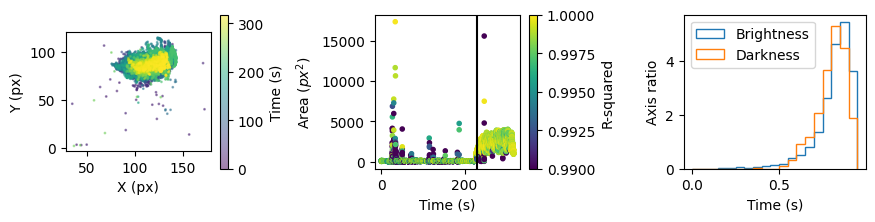

In [173]:
fits = ellipse_fits
dark_onset = fits.time.searchsorted(230)
fig = plt.figure(figsize=(10, 2))
ax = fig.add_subplot(1, 3, 1, aspect="equal")

sc = ax.scatter(fits.centre_x, fits.centre_y, s=1, alpha=0.5, c=fits.time)
cb = plt.colorbar(sc)
cb.set_label("Time (s)")
ax.set_xlabel("X (px)")
ax.set_ylabel("Y (px)")

ax = fig.add_subplot(1, 3, 2)
sc = ax.scatter(fits.time, fits.area, c=fits.rsquare, vmin=0.99, vmax=1, marker=".")
cb = plt.colorbar(sc)
cb.set_label("R-squared")
ax.axvline(fits.time[dark_onset], color="k")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Area ($px^2$)")

fig.subplots_adjust(wspace=0.7, left=0.1)

ax = fig.add_subplot(1, 3, 3)
ax.hist(
    fits.excentricity[:dark_onset],
    bins=np.arange(0, 1, 0.05),
    histtype="step",
    density=True,
    label="Brightness",
)
ax.hist(
    fits.excentricity[dark_onset:],
    bins=np.arange(0, 1, 0.05),
    histtype="step",
    density=True,
    label="Darkness",
)
ax.legend(loc="upper left")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Axis ratio")
fig.subplots_adjust(wspace=0.7, left=0.1)


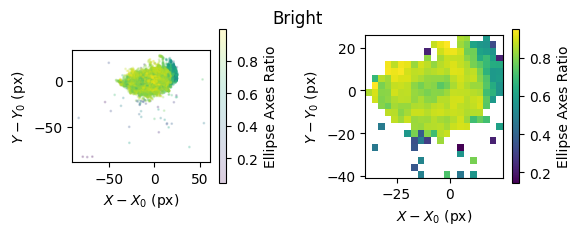

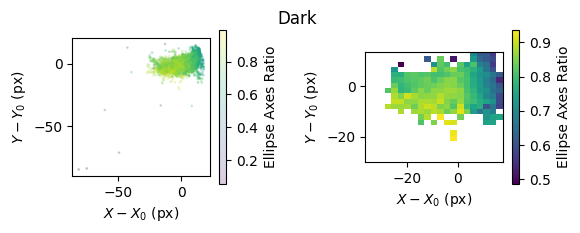

In [179]:
datasets = [fits[:dark_onset], fits[dark_onset:]]

for label, data in zip(["Bright", "Dark"], datasets):
    data = data.copy()
    fig = plt.figure(figsize=(6, 2))
    fig.suptitle(label)
    center = data[["centre_x", "centre_y"]].mean(axis=0)
    x = data["centre_x"] - center["centre_x"]
    y = data["centre_y"] - center["centre_y"]
    ax = fig.add_subplot(1, 2, 1, aspect="equal")
    sc = ax.scatter(x, y, c=data["excentricity"], alpha=0.2, s=1)
    cb = plt.colorbar(sc)
    cb.set_label("Ellipse Axes Ratio")
    ax.set_xlabel("$X - X_0$ (px)")
    ax.set_ylabel("$Y - Y_0$ (px)")
    lx, hx = np.quantile(x, [0.001, 0.999])
    xb = np.round((x - lx) / (hx - lx) * 20, 0)
    xb[(xb < 0) | (xb > 20)] = np.nan
    data["xb"] = xb
    ly, hy = np.quantile(y, [0.001, 0.999])
    yb = np.round((y - ly) / (hy - ly) * 20, 0)
    yb[(yb < 0) | (yb > 20)] = np.nan
    data["yb"] = yb
    matrix_df = data.groupby(["xb", "yb"]).aggregate(np.nanmedian).excentricity
    matrix = np.zeros((21, 21)) + np.nan
    for x, y in matrix_df.index:
        matrix[int(y), int(x)] = matrix_df.loc[(x, y)]
    ax = fig.add_subplot(1, 2, 2, aspect="equal")
    img = ax.imshow(matrix, extent=(lx, hx, ly, hy), origin="lower")
    cb = plt.colorbar(img)
    cb.set_label("Ellipse Axes Ratio")
    ax.set_xlabel("$X - X_0$ (px)")
    ax.set_ylabel("$Y - Y_0$ (px)")

    fig.subplots_adjust(wspace=0.7)


In [194]:
len(dlc_res)


19070

/tmp/ipykernel_270678/76111285.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  reflection = dlc[model_part, 'reflection']
/tmp/ipykernel_270678/76111285.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  reflection = dlc[model_part, 'reflection']


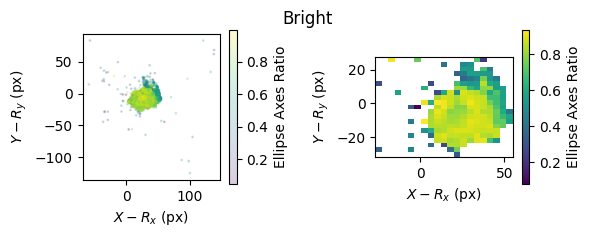

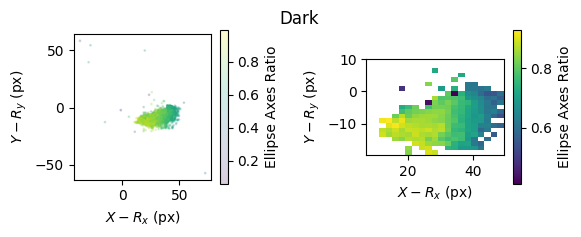

In [197]:
datasets = [fits[:dark_onset], fits[dark_onset:]]
dlc_datasets = [dlc_res.iloc[:dark_onset], dlc_res.iloc[dark_onset:]]

model_part = model.find("DLC_resnet")
model_part = model[model_part:-3]
for label, data, dlc in zip(["Bright", "Dark"], datasets, dlc_datasets):
    data = data.copy()
    reflection = dlc[model_part, "reflection"]
    fig = plt.figure(figsize=(6, 2))
    fig.suptitle(label)

    x = data["centre_x"] - reflection["x"].values
    y = data["centre_y"] - reflection["y"].values
    ax = fig.add_subplot(1, 2, 1, aspect="equal")
    sc = ax.scatter(x, y, c=data["excentricity"], alpha=0.2, s=1)
    cb = plt.colorbar(sc)
    cb.set_label("Ellipse Axes Ratio")
    ax.set_xlabel("$X - R_x$ (px)")
    ax.set_ylabel("$Y - R_y$ (px)")
    lx, hx = np.quantile(x, [0.001, 0.999])
    xb = np.round((x - lx) / (hx - lx) * 20, 0)
    xb[(xb < 0) | (xb > 20)] = np.nan
    data["xb"] = xb
    ly, hy = np.quantile(y, [0.001, 0.999])
    yb = np.round((y - ly) / (hy - ly) * 20, 0)
    yb[(yb < 0) | (yb > 20)] = np.nan
    data["yb"] = yb
    matrix_df = data.groupby(["xb", "yb"]).aggregate(np.nanmedian).excentricity
    matrix = np.zeros((21, 21)) + np.nan
    for x, y in matrix_df.index:
        matrix[int(y), int(x)] = matrix_df.loc[(x, y)]
    ax = fig.add_subplot(1, 2, 2, aspect="equal")
    img = ax.imshow(matrix, extent=(lx, hx, ly, hy), origin="lower")
    cb = plt.colorbar(img)
    cb.set_label("Ellipse Axes Ratio")
    ax.set_xlabel("$X - R_x$ (px)")
    ax.set_ylabel("$Y - R_y$ (px)")

    fig.subplots_adjust(wspace=0.7)


# Find eye centre

To find the eye center we will use the average excentricity for each eye position.
If we fit an ellipse, the excentricity of the ellipse should depend on the distance 

$Pupil Axes Ratio = \frac{\sqrt{(x-x_0)^2 + (y-y_0)^2}}{R}$ 

In [225]:
from scipy.optimize import minimize


def ideal_ratio(params, xy):
    x0, y0, r = params
    return np.sqrt((xy[:, 0] - x0) ** 2 + (xy[:, 1] - y0) ** 2) / r


def find_centre(x, y, ratio):
    data = np.hstack([x.reshape((-1, 1)), y.reshape((-1, 1))])

    def cost(params):
        estimate = ideal_ratio(params, data)
        return np.sqrt(np.sum((estimate - ratio) ** 2))

    return minimize(cost, (0, 0, 10))


/tmp/ipykernel_270678/3138524388.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  reflection = dlc[model_part, 'reflection']


[120.83127014  30.9995885  122.1781595 ]
[197.8324073  196.75725125 321.45884883]


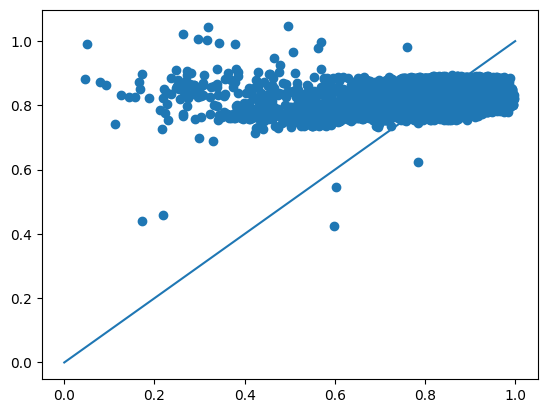

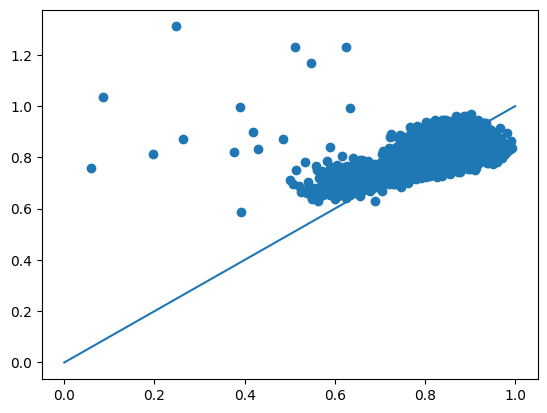

In [226]:
# Fit using all data
res = dict()
for label, data, dlc in zip(["Bright", "Dark"], datasets, dlc_datasets):
    data = data.copy()
    reflection = dlc[model_part, "reflection"]
    x = data["centre_x"] - reflection["x"].values
    y = data["centre_y"] - reflection["y"].values
    res[label] = find_centre(x.values, y.values, data["excentricity"].values)
    plt.figure()
    xy = np.hstack([x.values.reshape((-1, 1)), y.values.reshape((-1, 1))])
    plt.scatter(data["excentricity"], ideal_ratio(res[label]["x"], xy))
    plt.plot([0, 1], [0, 1])

print(res["Dark"]["x"])
print(res["Bright"]["x"])


/tmp/ipykernel_270678/4212030936.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  reflection = dlc[model_part, 'reflection']
/tmp/ipykernel_270678/4212030936.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  reflection = dlc[model_part, 'reflection']


[ -24851.32971093 -106380.98982383  139991.88522619]
[-7.08993716 63.50075454 79.83395347]


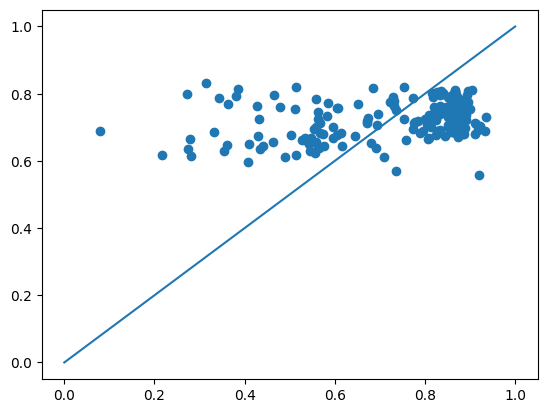

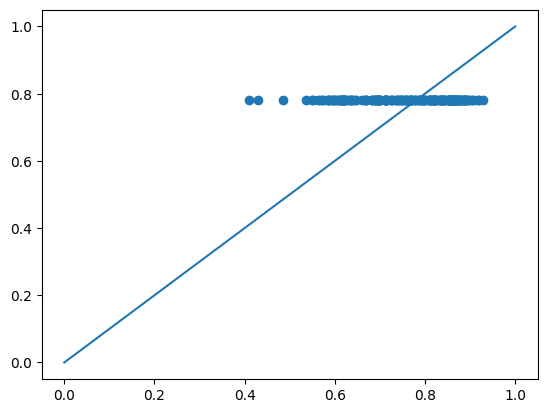

In [244]:
# Fit using matreix data
res = dict()
for label, data, dlc in zip(["Bright", "Dark"], datasets, dlc_datasets):
    data = data.copy()
    reflection = dlc[model_part, "reflection"]
    x = data["centre_x"] - reflection["x"].values
    y = data["centre_y"] - reflection["y"].values
    lx, hx = np.quantile(x, [0.001, 0.999])
    xb = np.round((x - lx) / (hx - lx) * 20, 0)
    xb[(xb < 0) | (xb > 20)] = np.nan
    data["xb"] = xb
    ly, hy = np.quantile(y, [0.001, 0.999])
    yb = np.round((y - ly) / (hy - ly) * 20, 0)
    yb[(yb < 0) | (yb > 20)] = np.nan
    data["yb"] = yb
    matrix_df = data.groupby(["xb", "yb"]).aggregate(np.nanmedian).excentricity
    xvals = matrix_df.index.get_level_values(0).values
    yvals = matrix_df.index.get_level_values(1).values
    excvals = matrix_df.values
    res[label] = find_centre(xvals, yvals, excvals)
    plt.figure()
    xy = np.hstack([xvals.reshape((-1, 1)), yvals.reshape((-1, 1))])
    plt.scatter(excvals, ideal_ratio(res[label]["x"], xy))
    plt.plot([0, 1], [0, 1])

print(res["Dark"]["x"])
print(res["Bright"]["x"])


In [243]:
xvals


Float64Index([-0.0, -0.0,  2.0,  3.0,  5.0,  5.0,  5.0,  5.0,  6.0,  6.0,
              ...
              19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 20.0, 20.0, 20.0],
             dtype='float64', name='xb', length=187)

In [22]:
15 / 4


3.75